You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/smoothing.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/smoothing.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/smoothing.ipynb).

# Temporal and Spatial Smoothing

This demo demonstrates `climpred`'s capabilities to postprocess decadal prediction output before skill verification.
Here, we showcase a set of methods to smooth out noise in the spatial and temporal domain.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from climpred import PerfectModelEnsemble, HindcastEnsemble
from climpred.tutorial import load_dataset
import matplotlib.pylab as plt
import xarray as xr

<IPython.core.display.Javascript object>

In [3]:
# Sea surface temperature
v = "tos"
initialized3d = load_dataset("MPI-PM-DP-3D")[v]
control3d = load_dataset("MPI-control-3D")[v]

<IPython.core.display.Javascript object>

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years`, `seasons`, `months`, `weeks`, `pentads`, `days`, `hours`, `minutes`, `seconds`.  For the this data, the `lead` `units` are `years`. 

In [4]:
initialized3d["lead"].attrs = {"units": "years"}

<IPython.core.display.Javascript object>

## Temporal smoothing

In order to reduce temporal noise, decadal predictions are recommended to take multi-year averages {cite:p}`Goddard2013`.

In [5]:
pm = PerfectModelEnsemble(initialized3d).add_control(control3d)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<IPython.core.display.Javascript object>

{py:meth}`.PerfectModelEnsemble.smooth` `({"time":x})` aggregates over `x` timesteps in time dimensions `lead` and `time`. Here it does not matter whether you specify `lead` or `time`, temporal smoothing is applied to both time dimensions. Note that the time dimension labels are not changed by this temporal smoothing immediately.

In [6]:
pm_tsmoothed = pm.smooth({"lead": 3})
print("initialized", pm_tsmoothed.get_initialized().coords, "\n")
print("control", pm_tsmoothed.get_control().coords)

initialized Coordinates:
    lon         (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat         (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * lead        (lead) int64 1 2 3
  * init        (init) object 3014-01-01 00:00:00 ... 3237-01-01 00:00:00
  * member      (member) int64 1 2 3 4
    valid_time  (lead, init) object 3015-01-01 00:00:00 ... 3240-01-01 00:00:00 

control Coordinates:
    lon      (y, x) float64 -47.25 -47.69 -48.12 -48.54 ... 131.3 132.5 133.8
    lat      (y, x) float64 76.36 76.3 76.24 76.17 ... -77.25 -77.39 -77.54
  * time     (time) object 3000-01-01 00:00:00 ... 3047-01-01 00:00:00


<IPython.core.display.Javascript object>

But after calling {py:meth}`.PerfectModelEnsemble.verify`, the correct time aggregation label is automatically set.

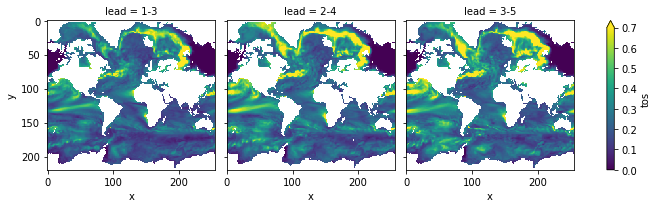

<IPython.core.display.Javascript object>

In [7]:
pm_tsmoothed.verify(metric="rmse", comparison="m2e", dim=["init", "member"])[v].plot(
    col="lead", vmin=0, vmax=0.7, yincrease=False, x="x"
)

Compare to the prediction skill without smoothing (with ``rmse`` smaller is better):

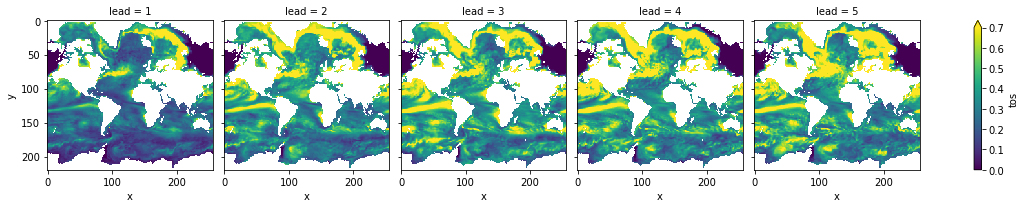

<IPython.core.display.Javascript object>

In [8]:
pm.verify(metric="rmse", comparison="m2e", dim=["init", "member"])[v].plot(
    col="lead", vmin=0, vmax=0.7, yincrease=False, x="x"
)

You can plot time-aggregated skill timeseries by specifying `x=lead_center` while plotting. Lead centers are placed in the center of the lead-aggregation boundaries. Note how the correlation of forecasts is increasing for longer time-aggregations because noise is smoothed out.

In [9]:
pm = PerfectModelEnsemble(load_dataset("MPI-PM-DP-1D"))
pm = pm.add_control(load_dataset("MPI-control-1D"))
pm_NA = pm.sel(area="North_Atlantic_SPG", period="DJF")[['tos']]

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<IPython.core.display.Javascript object>

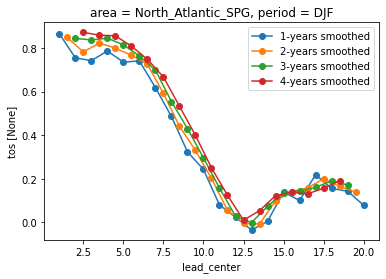

<IPython.core.display.Javascript object>

In [10]:
for time_agg in [1, 2, 3, 4]:
    pm_NA.smooth({"lead": time_agg}).verify(
        metric="acc", comparison="m2e", dim=["init", "member"]
    ).tos.plot(x="lead_center", marker="o", label=f"{time_agg}-years smoothed")
plt.legend()

Now, we showcase these smoothing features for {py:meth}`.HindcastEnsemble.smooth`.

In [11]:
v = "SST"
initialized = load_dataset("CESM-DP-SST-3D")[v]
reconstruction = load_dataset("FOSI-SST-3D")[v]
# Move reconstruction into proper anomaly space
reconstruction = reconstruction - reconstruction.sel(time=slice(1964, 2014)).mean(
    "time"
)

<IPython.core.display.Javascript object>

In [12]:
hindcast = HindcastEnsemble(initialized)
hindcast = hindcast.add_observations(reconstruction)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<IPython.core.display.Javascript object>

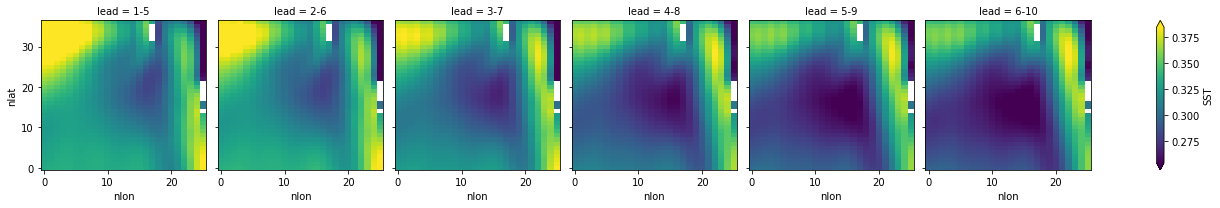

<IPython.core.display.Javascript object>

In [13]:
hindcast.smooth({"lead": 5}).verify(
    metric="rmse", comparison="e2r", dim="init", alignment="same_verif"
)[v].plot(col="lead", robust=True)

## Spatial smoothing
In order to reduce spatial noise, global decadal predictions are recommended to get regridded to a 5 degree longitude x 5 degree latitude grid as recommended {cite:p}`Goddard2013`.

In [14]:
v = "tos"
pm_ssmoothed = pm.smooth({"lon": 5, "lat": 5})
pm_ssmoothed.get_initialized().coords

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Coordinates:
  * lead        (lead) int64 1 2 3 4 5
  * init        (init) object 3014-01-01 00:00:00 ... 3237-01-01 00:00:00
  * member      (member) int64 1 2 3 4
    valid_time  (lead, init) object 3015-01-01 00:00:00 ... 3242-01-01 00:00:00
  * lon         (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * lat         (lat) float64 -83.97 -78.97 -73.97 -68.97 ... 81.03 86.03 91.03

<IPython.core.display.Javascript object>

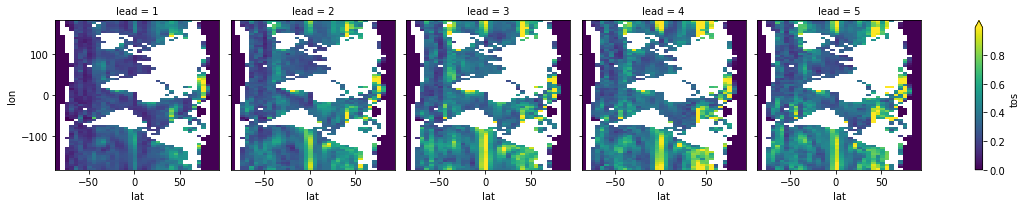

<IPython.core.display.Javascript object>

In [15]:
pm_ssmoothed.verify(metric="rmse", comparison="m2e", dim=["init", "member"])[v].T.plot(
    col="lead", robust=True, yincrease=True,
)

Spatial smoothing guesses the names corresponding to `lon` and `lat` in the coordinates of the {py:class}`.PredictionEnsemble` underlying datasets.

In [16]:
hindcast.get_initialized().coords

Coordinates:
    TLAT        (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336
    TLONG       (nlat, nlon) float64 250.8 251.9 253.1 ... 276.7 277.8 278.9
  * init        (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead        (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA       (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
    valid_time  (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00

<IPython.core.display.Javascript object>

In [17]:
hindcast.smooth({"lon": 1, "lat": 1}).get_initialized().coords

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Coordinates:
  * init        (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead        (lead) int32 1 2 3 4 5 6 7 8 9 10
    valid_time  (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
  * lon         (lon) float64 250.8 251.8 252.8 253.8 ... 277.8 278.8 279.8
  * lat         (lat) float64 -9.75 -8.75 -7.75 -6.75 ... -1.75 -0.7503 0.2497

<IPython.core.display.Javascript object>

{py:meth}`.HindcastEnsemble.smooth` `("goddard2013")` creates 4-year means and 5x5 degree regridding as suggested in {cite:p}`Goddard2013`.

In [18]:
pm.smooth("goddard2013").verify(
    metric="acc", comparison="m2e", dim=["init", "member"]
).coords

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Coordinates:
  * lead         (lead) <U3 '1-4' '2-5'
  * lon          (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * lat          (lat) float64 -83.97 -78.97 -73.97 -68.97 ... 81.03 86.03 91.03
    lead_center  (lead) float64 2.5 3.5

<IPython.core.display.Javascript object>

## References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```